In [11]:
import analyse
import MDAnalysis as mda
import matplotlib.pyplot as plt
import MDAnalysis.analysis.rms as rms

In [2]:
folder = '../6b73_hlrn/bepberta/6b73_hlrn/'

In [19]:
trajectory =  mda.Universe(folder+'step5_assembly.xplor_ext.psf', folder+'namd/step7.1_production.dcd')
ref = mda.Universe(folder+'6b73_fin.pdb')

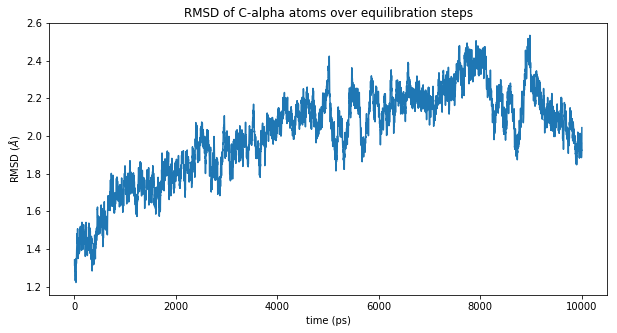

In [20]:
R = analyse.rmsd_traj(trajectory, ref, plot=True)

In [21]:
first_frame = trajectory.select_atoms('name CA').positions[0]

In [22]:
R = rms.RMSD(trajectory.select_atoms('name CA'), first_frame).run()
R = R.rmsd.T
frame = R[0]
time = R[1]

plt.figure(figsize=(10,5))
plt.plot(time, R[2])
plt.ylabel('RMSD ($\AA$)')
plt.xlabel('time (ps)')
plt.title('RMSD of C-alpha atoms over equilibration steps')
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'select_atoms'

In [5]:
pdb_file = folder+'6b73_fin.pdb'
struct = analyse.secondary_structure(pdb_file)

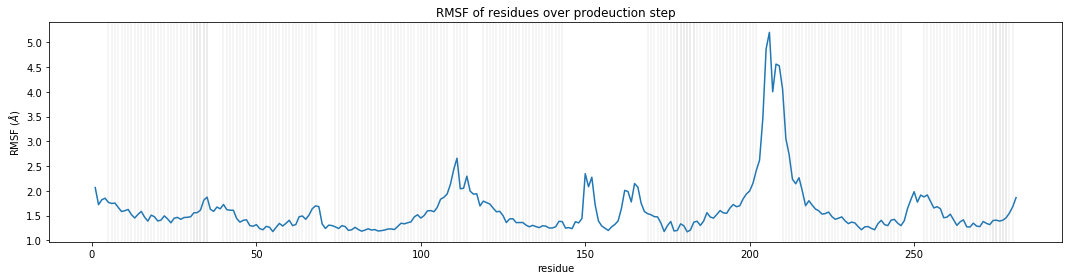

In [6]:
analyse.rmsf_plot([trajectory], title='RMSF of residues over prodeuction step', structure=struct)

In [ ]:
import MDAnalysis.analysis.hbonds

h = MDAnalysis.analysis.hbonds.HydrogenBondAnalysis(trajectory, 'protein', 'name TIP3P', distance=3.0, angle=120.0)
h.run()

/home/bertalae93/miniconda3/lib/python3.7/site-packages/MDAnalysis/analysis/hbonds/hbond_analysis.py:649: SelectionWarning: No acceptors found in selection 2. You might have to specify a custom 'acceptors' keyword. Selection will update so continuing with fingers crossed.
  warnings.warn(errmsg, category=SelectionWarning)
/home/bertalae93/miniconda3/lib/python3.7/site-packages/MDAnalysis/analysis/hbonds/hbond_analysis.py:649: SelectionWarning: No donors found in selection 2. You might have to specify a custom 'donors' keyword. Selection will update so continuing with fingers crossed.
  warnings.warn(errmsg, category=SelectionWarning)
